In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
!nvidia-smi

Thu Mar  9 22:14:22 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070       WDDM | 00000000:10:00.0  On |                  N/A |
|  0%   43C    P3               39W / 270W|   2808MiB /  8192MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
tensor_transform = transforms.ToTensor()

dataset = datasets.MNIST(root='./data', 
                         train=True,
                         download=True,
                         transform=tensor_transform)

loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=32,
                                     shuffle=True)

In [4]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [41]:
model = AE()

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-1,
                             weight_decay=1e-8)

epochs = 20
outputs = []
losses = []

In [42]:
for epoch in tqdm(range(epochs)):
    running_loss = 0
    for (image, _) in loader:

        image = image.reshape(-1, 784)

        reconstructed = model(image)

        loss = loss_function(reconstructed, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * image.shape[0]

    losses.append(running_loss / len(dataset))
    outputs.append((epoch, image, reconstructed))

100%|██████████| 20/20 [04:27<00:00, 13.38s/it]


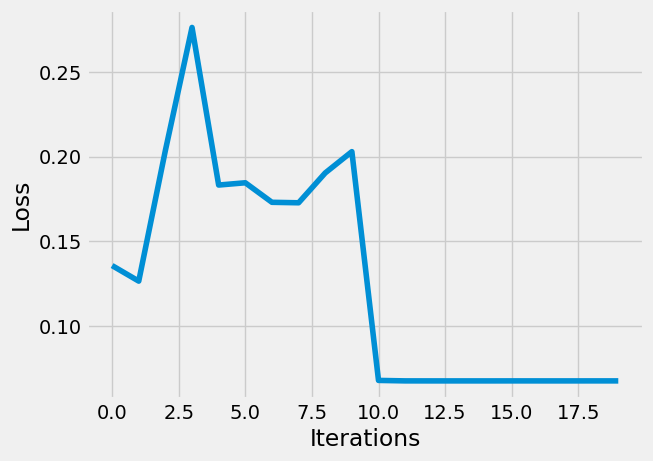

In [43]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
plt.plot(losses)

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, len(param.data))

encoder.0.weight 128
encoder.0.bias 128
encoder.2.weight 64
encoder.2.bias 64
encoder.4.weight 36
encoder.4.bias 36
encoder.6.weight 18
encoder.6.bias 18
encoder.8.weight 9
encoder.8.bias 9
decoder.0.weight 18
decoder.0.bias 18
decoder.2.weight 36
decoder.2.bias 36
decoder.4.weight 64
decoder.4.bias 64
decoder.6.weight 128
decoder.6.bias 128
decoder.8.weight 784
decoder.8.bias 784


In [44]:
e, img, recon = outputs[-1]

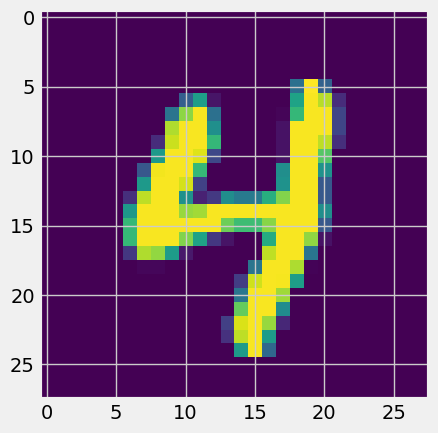

In [45]:
for i, item in enumerate(img):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])

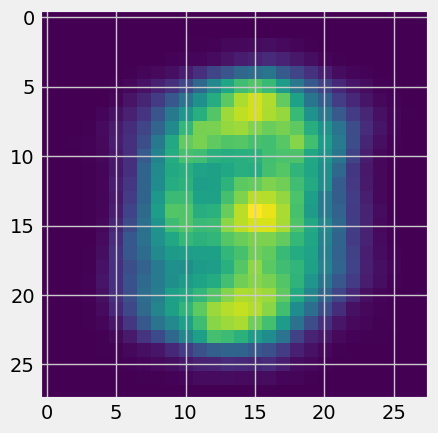

In [46]:
for i, item in enumerate(recon.detach().numpy()):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0])